In [1]:
#%%

# basic
import os 
import re 
import warnings
import numpy as np 
import pandas as pd 
import datetime as dt

# Regression & Data Import
import statsmodels.api as sm 
from pandas_datareader import data as pdr
warnings.filterwarnings("ignore")


# matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker


We load in a DataSet which recorded the Mood'ys rating action report  ,

each report will classify as fout type of event , 

upgrade  , downgrade , assigned , others , 

we gona check whether moody's rating action report affect 

equity market with bad news (downgrade event)

# Prepare Data : Fama-French , Equity Price , Tickers
  --> everything we need to build Cumulative Abnormal Return . 

In [2]:
Event_Data  = pd.read_excel(r'/Users/chen-lichiang/Desktop/Rating Agency/Analysis_Detail_Moody_Data.xlsx')
ticker_list = list( set(Event_Data['ticker'].to_list()) )
print(ticker_list)

['MTB', 'SEE', 'MLM', 'MAS', 'DIS', 'TRMB', 'APTV', 'IPGP', 'CHRW', 'NEE', 'AMGN', 'FIS', 'VIAC', 'WMB', 'LEN', 'WAB', 'VTRS', 'FOXA', 'AVGO', 'CMI', 'TAP', 'PRGO', 'HES', 'PWR', 'JNJ', 'EIX', 'FDX', 'CCI', 'WRK', 'CLX', 'SIVB', 'AXP', 'CAH', 'NTAP', 'EFX', 'CAT', 'FRC', 'AEE', 'COF', 'RE', 'PEG', 'GS', 'TWTR', 'KR', 'PHM', 'FLT', 'IP', 'BKNG', 'PH', 'WHR', 'FISV', 'EXR', 'MSFT', 'AMAT', 'AIG', 'TXT', 'KLAC', 'MCHP', 'NI', 'LNT', 'DISCA', 'LNC', 'CME', 'AZO', 'KSU', 'WMT', 'XLNX', 'KEYS', 'SYY', 'DRI', 'ABT', 'FMC', 'CE', 'V', 'TXN', 'OXY', 'ALLE', 'EMR', 'STE', 'IRM', 'EA', 'CARR', 'CZR', 'HAL', 'DISH', 'D', 'PM', 'WEC', 'TT', 'FRT', 'NCLH', 'MKC', 'UAL', 'LIN', 'WELL', 'VMC', 'HOLX', 'UPS', 'CAG', 'PSA', 'STT', 'FANG', 'MU', 'C', 'WLTW', 'DUK', 'SBUX', 'SJM', 'FCX', 'OMC', 'BBY', 'EL', 'HSY', 'KIM', 'OKE', 'AAP', 'ETN', 'GOOG', 'LLY', 'DHR', 'PFE', 'NSC', 'UDR', 'USB', 'LKQ', 'BRK.B', 'ADM', 'CNP', 'CRM', 'PENN', 'AAPL', 'F', 'EOG', 'HIG', 'RF', 'LW', 'VTR', 'CBOE', 'AON', 'COO', 'PK

In [3]:
class Company_Data():
    """
    ticker     --> list (str)
    start ,end --> datetime 
    peirods    --> string
    """
    def __init__(self,tickers,start,end,periods):

        self.start   = start 
        self.end     = end 
        self.tickers = tickers
        self.periods = periods
    
    def get_data(self,ticker):

        self.df = pdr.get_data_yahoo(ticker,self.start,self.end).reset_index()
   
        return self.df 
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        
    def get_price_data(self):

        for i , ticker in enumerate(self.tickers) : 
            
            if i == 0 :

                Price_DF = self.get_data(ticker)
                Price_DF = Price_DF[['Date','Close']]
                Price_DF.columns = ['Date','Price']

            else:
                Merge_DF = self.get_data(ticker)[['Date','Close']]
                Merge_DF.columns = ['Date','Price']
                Price_DF = Price_DF.merge(Merge_DF,how='outer')
        
        Price_DF = Price_DF.fillna(value=0)
        Price_DF['Date'] = Price_DF.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        Price_DF.index = Price_DF['Date']
        Price_DF = Price_DF.drop(['Date'],axis=1)

        return Price_DF



class Ken_French_Library():
    """
    Fama/French 3 Factors [Weekly]
    Fama/French 3 Factors [Daily]
    """

    def __init__(self,start,periods):

        self.start = start 
        self.periods = periods
    
    def get_data(self):

        research_factors = pdr.DataReader('F-F_Research_Data_Factors_'+str(self.periods),
                                      'famafrench', start=self.start)[0]
        momentum_factor = pdr.DataReader('F-F_Momentum_Factor_daily',
                                     'famafrench', start=self.start)[0]

        five_factors = research_factors.join(momentum_factor).dropna()
        five_factors /= 100.
        five_factors.index = five_factors.index.tz_localize('utc')

        five_factors.columns = five_factors.columns.str.strip()

        self.five_factors = pd.DataFrame(five_factors)
        self.five_factors = self.five_factors.reset_index()
        self.five_factors['Date'] = self.five_factors.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        self.five_factors.index   = self.five_factors['Date']
        self.five_factors = self.five_factors.drop(['Date'],axis=1)
        
        return self.five_factors
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        

    def __len__(self):
        return self.five_factors.shape[0]


Fama_French =  Ken_French_Library(start=dt.datetime(1995,1,1),periods='Daily')
FF_DF       =  Fama_French.get_data()
FF_DF

,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,
1995-01-03,-0.0026,-0.0097,0.0093,0.0002,-0.0117
1995-01-04,0.0033,-0.0031,0.0049,0.0002,-0.0058
1995-01-05,-0.0005,0.0005,0.0006,0.0002,-0.0038
1995-01-06,0.0018,0.0001,0.0012,0.0002,0.0001
1995-01-09,0.0008,0.0002,0.0014,0.0002,-0.0027
...,...,...,...,...,...
2021-06-24,0.0068,0.0062,0.0023,0.0000,0.0071
2021-06-25,0.0032,-0.0068,0.0046,0.0000,-0.0058
2021-06-28,0.0023,-0.0048,-0.0159,0.0000,0.0011


In [4]:
def Fama_French_Predict_Return(Regression_Df):

    
    def OLS_Linear_Regression(y,x,print=None):

        # linear Regression
        x     = sm.add_constant(x)
        model = sm.OLS(y,x)
        res   = model.fit()

        # Print Summary
        if print :
            print(res.summary())

        return res.params


    # Famma_French_Predict_Return . 
    x = Regression_Df[['Mkt-RF','SMB','HML']].values 
    x = sm.add_constant(x)
    y = Regression_Df['Returns'].values
    parameters   = OLS_Linear_Regression(y,x)

    # Predicted Abnormal Returns .
    predict_returns = np.dot(x,parameters)
    Regression_Df['Preditc Return']  = predict_returns
    Regression_Df['Abnormal Return'] = Regression_Df['Returns'] - Regression_Df['Preditc Return'] - Regression_Df['RF'] 

    return Regression_Df


def Calculate_Cumulative_Abnormal_Return(Regression_Df):


    Date_list = []
    Short_Term_Cumulative_Abnormal_Return = []
    Long_Term_Cumulative_Abnormal_Return  = []


    for i in range(Regression_Df.shape[0]):
        
        try:

            date = Regression_Df.index.to_list()[i]
            Short_Term_CAR  = np.sum( Regression_Df['Abnormal Return'][i-1:i+2].values  )
            Long_Term_CAR   = np.sum( Regression_Df['Abnormal Return'][i+3:i+31].values )

            Date_list.append(date)
            Short_Term_Cumulative_Abnormal_Return.append(Short_Term_CAR)
            Long_Term_Cumulative_Abnormal_Return.append(Long_Term_CAR)
            
        except:
            pass

    # ---- Abnormal DataFrame
    Abnormal_Return_Df = pd.DataFrame()
    Abnormal_Return_Df['Date']      = Date_list
    Abnormal_Return_Df['CAR[-1,1]'] = Short_Term_Cumulative_Abnormal_Return
    Abnormal_Return_Df['CAR[2,30]'] = Long_Term_Cumulative_Abnormal_Return
    Abnormal_Return_Df.index = Abnormal_Return_Df['Date'] 
    Abnormal_Return_Df = Abnormal_Return_Df.drop(['Date'],axis=1)

    Regression_Df = pd.merge(Regression_Df,Abnormal_Return_Df,right_index=True,left_index=True)

    return Abnormal_Return_Df,Regression_Df


def Address_Date(date):

    date =str(date)
    
    return date[:10]


In [ ]:
Output_Regression_DF = pd.DataFrame()

for i in range(len(ticker_list)) :


    ticker  = str(ticker_list[i])
    start   = dt.datetime(2000,1,1)
    end     = dt.datetime.now()
    tickers = [str(ticker)]
    print("working on : ",ticker)
    
    # ------------ ------------ ------------ ------------ 

    try :

        Company_Price       = Company_Data(tickers=tickers,start=start,end=end,periods="Daily")
        Stock_DF            = Company_Price.get_price_data()
        Stock_DF['Returns'] = Stock_DF['Price'].pct_change().dropna()
        Stock_DF = Stock_DF.dropna()


        Regression_Df           = Stock_DF
        Regression_Df['Ticker'] = ticker
        Regression_Df           = pd.merge(Regression_Df,FF_DF,left_index=True, right_index=True)

        Regression_Df = Regression_Df[Regression_Df['Returns'].notna()]
        Regression_Df = Fama_French_Predict_Return(Regression_Df)
        Abnormal_Return_Df,Regression_Df = Calculate_Cumulative_Abnormal_Return(Regression_Df)

        Test_Data          = Event_Data[Event_Data['ticker']==str(ticker)]
        Test_Data['Date']  = Test_Data['Event Time']
        Test_Data['Date'] = Test_Data.apply(lambda x : Address_Date(x['Date']),axis=1)
        Test_Data.index    = Test_Data['Date']
        Test_Data          = Test_Data.drop(['Date'],axis=1)



        Regression_Df = pd.merge(Regression_Df,Test_Data,right_index=True,left_index=True,how='left')
        if i == 0 :
            Output_Regression_DF = Regression_Df
        else : 
            Output_Regression_DF = pd.concat([Output_Regression_DF,Regression_Df])
    
    except :
        pass 


In [25]:
Output_Regression_DF.dropna()

,Price,Returns,Ticker,Mkt-RF,SMB,HML,RF,Mom,Preditc Return,Abnormal Return,...,ticker,index,Negative,Positive,Uncertainty,Negative Sentiment,Event_Assigned,Event_Downgrade,Event_Others,Event_Upgrade
Date,,,,,,,,,,,,,,,,,,,,,
2000-05-18,40.531250,0.010912,MTB,-0.0109,-0.0111,0.0082,0.00023,-0.0119,-0.001128,0.011810,...,MTB,Apperances,4.0,15.0,670.0,-0.015965,1,0,0,0
2000-10-30,50.000000,-0.002991,MTB,0.0074,-0.0165,0.0186,0.00025,-0.0206,0.029027,-0.032268,...,MTB,Apperances,0.0,28.0,964.0,-0.028226,0,0,0,1
2002-09-26,80.110001,0.072710,MTB,0.0174,-0.0081,0.0091,0.00007,0.0101,0.027543,0.045098,...,MTB,Apperances,4.0,0.0,750.0,0.005305,0,1,0,0
2002-11-18,78.739998,-0.023683,MTB,-0.0100,0.0030,-0.0018,0.00006,-0.0078,-0.011654,-0.012089,...,MTB,Apperances,40.0,0.0,781.0,0.048721,0,1,0,0
2003-09-23,86.980003,-0.002523,MTB,0.0065,0.0052,0.0001,0.00004,0.0057,0.006786,-0.009349,...,MTB,Apperances,14.0,9.0,546.0,0.008787,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-28,76.400002,-0.031440,AMD,-0.0341,0.0006,0.0057,0.00000,0.0017,-0.056115,0.024674,...,AMD,Apperances,0.0,9.0,283.0,-0.030822,0,0,0,1
2010-01-25,34.160000,-0.006399,ADBE,0.0037,-0.0019,0.0033,0.00000,0.0054,0.003159,-0.009558,...,ADBE,Apperances,7.0,18.0,604.0,-0.017488,1,0,0,0
2015-01-21,71.540001,0.000699,ADBE,0.0042,-0.0096,0.0057,0.00000,-0.0100,0.001592,-0.000893,...,ADBE,Apperances,3.0,15.0,428.0,-0.026906,1,0,0,0


In [7]:
def Construct_Asset_Event_Plot_Df(Output_Regression_DF,ticker):


    def Get_Plot_Df(Ｄowngrade_Event,Ｄowngrade_Event_CAR):

        Plot_Df          = pd.DataFrame(Ｄowngrade_Event_CAR).transpose()
        Plot_Df .columns = Ｄowngrade_Event

        Plot_Df [str(ticker) + ' Mean'] = Plot_Df.mean(axis=1)
        Plot_Df                         = pd.DataFrame(Plot_Df[str(ticker) + ' Mean']) # 只留個別公司 Event 的平均

        return Plot_Df


    Ticker_Event_Df = Output_Regression_DF[Output_Regression_DF['Ticker']==str(ticker)].reset_index(drop=True)

    # Downgrade
    Ｄowngrade_Event     = []
    Ｄowngrade_Event_CAR = []

    # Upgrade
    Upgrade_Event       = []
    Upgrade_Event_CAR   = []

    # Assigned
    Assigned_Event      = []
    Assigned_Event_CAR  = []


    Ticker_Date  = Ticker_Event_Df.index.to_list()

    for i in range( Ticker_Event_Df.shape[0] ) : 

        event = Ticker_Event_Df['Event'][i] 
  
        if event == 'Downgrade' : 
            
            Ｄowngrade_Event.append(Ticker_Date[i])
            Ｄowngrade_Event_CAR.append(Ticker_Event_Df['Abnormal Return'][i-15:i+60].values)
        
        elif event == 'Upgrade' :
            
            Upgrade_Event.append(Ticker_Date[i])
            Upgrade_Event_CAR.append(Ticker_Event_Df['Abnormal Return'][i-15:i+60].values)

        elif event == 'Assigned' :
            
            Assigned_Event.append(Ticker_Date[i])
            Assigned_Event_CAR.append(Ticker_Event_Df['Abnormal Return'][i-15:i+60].values)

            


    Downgrade_Plot_Df = Get_Plot_Df(Ｄowngrade_Event , Ｄowngrade_Event_CAR  )
    Upgrade_Plot_Df   = Get_Plot_Df(Upgrade_Event    , Upgrade_Event_CAR     )
    Assigned_Plot_Df  = Get_Plot_Df(Assigned_Event   , Assigned_Event_CAR    )


    try:
        Downgrade_Plot_Df.index              = index
        Upgrade_Plot_Df.index                = index
        Assigned_Plot_Df .index              = index

    except:
        pass
    
    return Downgrade_Plot_Df,Upgrade_Plot_Df,Assigned_Plot_Df



In [ ]:
tickers = list(set(Output_Regression_DF['Ticker'].to_list()))

for i,ticker in enumerate(tickers) : 
    
    Construct_Asset_Event_Plot_Df(Output_Regression_DF,ticker=ticker)

    if i == 0:

        Downgrade_Plot_Df,Upgrade_Plot_Df,Assigned_Plot_Df       = Construct_Asset_Event_Plot_Df(Output_Regression_DF,ticker=ticker)

    else:
        Downgrade_Equity_Df,Upgrade_Equity_Df,Assigned_Equity_Df = Construct_Asset_Event_Plot_Df(Output_Regression_DF,ticker=ticker)

        Downgrade_Plot_Df   = pd.concat( [Downgrade_Plot_Df , Downgrade_Equity_Df ] , axis=1 )
        Upgrade_Plot_Df     = pd.concat( [Upgrade_Plot_Df   , Upgrade_Equity_Df   ] , axis=1 )
        Assigned_Plot_Df    = pd.concat( [Assigned_Plot_Df  , Assigned_Equity_Df  ] , axis=1 )


index = np.arange(-15,60,1)
Downgrade_Plot_Df.index = index 
Upgrade_Plot_Df.index   = index 
Assigned_Plot_Df.index  = index 
Downgrade_Plot_Df

# Look at the CAR Visually

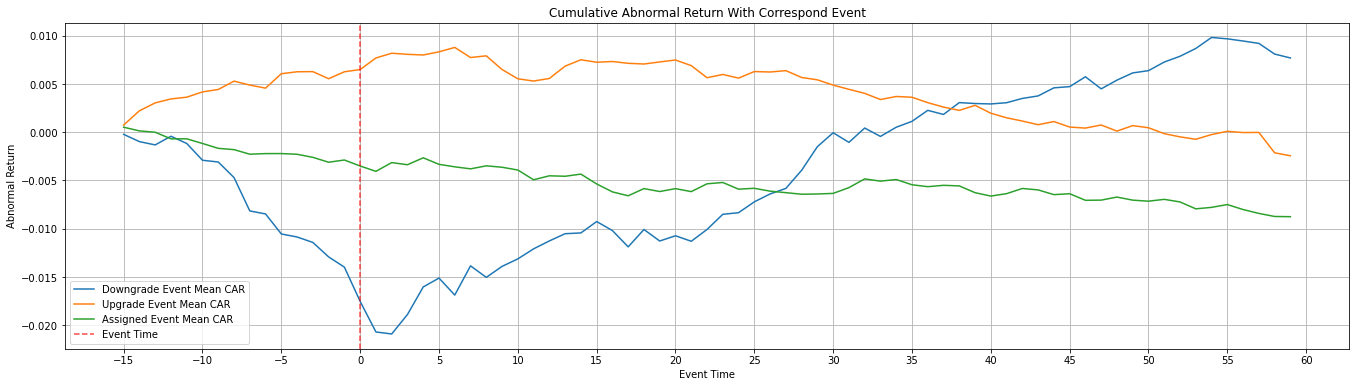

In [19]:
def Plot_Figure(Downgrade_Plot_Df,Upgrade_Plot_Df,Assigned_Plot_Df) :

    fig,ax = plt.subplots(figsize=(23,6))
    ax.set_title('Cumulative Abnormal Return With Correspond Event')

    # for col in Cols :
    #     ax.plot(Plot_Df.index , np.cumsum(Plot_Df[col]),label=str(col),alpha=0.3)

    ax.plot(Downgrade_Plot_Df.index , np.cumsum(Downgrade_Plot_Df.mean(axis=1)) , label='Downgrade Event Mean CAR')
    ax.plot(Upgrade_Plot_Df.index   , np.cumsum(Upgrade_Plot_Df.mean(axis=1))   , label='Upgrade Event Mean CAR'  )
    ax.plot(Assigned_Plot_Df.index  , np.cumsum(Assigned_Plot_Df.mean(axis=1))  , label='Assigned Event Mean CAR' )

    ax.axvline(0,label='Event Time',color='red',linestyle='--',alpha=0.7)
    ax.set_ylabel('Abnormal Return')
    ax.set_xlabel('Event Time')

    loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)

    ax.legend()
    ax.grid()

    return fig


fig = Plot_Figure(Downgrade_Plot_Df,Upgrade_Plot_Df,Assigned_Plot_Df)

# Look at Event's Return Reversl statistically

In [20]:
Output_Regression_DF = pd.get_dummies(Output_Regression_DF,columns=['Event'])
Output_Regression_DF.columns

Index(['Price', 'Returns', 'Ticker', 'Mkt-RF', 'SMB', 'HML', 'RF', 'Mom',
       'Preditc Return', 'Abnormal Return', 'CAR[-1,1]', 'CAR[2,30]',
       'Event Time', 'Event Time.1', 'Title', 'ticker', 'index', 'Negative',
       'Positive', 'Uncertainty', 'Negative Sentiment', 'Event_Assigned',
       'Event_Downgrade', 'Event_Others', 'Event_Upgrade'],
      dtype='object')

In [21]:
import statsmodels.api as sm 


dependent_vairable = ['Event_Upgrade','Event_Downgrade','Event_Others']


def OLS_Linear_Regression(y,x,dependent_vairable,constant=None):

    # linear Regression

    if constant : 

        x = sm.add_constant(x)
        model = sm.OLS(y,x)
        res   = model.fit()
        constant = ['Constant']
        constant.extend(dependent_vairable)

    else :

        model = sm.OLS(y,x)
        res   = model.fit()
        constant = []
        constant.extend(dependent_vairable)

    # Print Summary
    print(res.summary(xname=constant) )

    return res.params

x = Output_Regression_DF[dependent_vairable].values 

Short_Term_y = Output_Regression_DF['CAR[-1,1]'].values 
Long_Term_y  = Output_Regression_DF['CAR[2,30]'].values 

In [22]:
OLS_Linear_Regression(Short_Term_y,x,dependent_vairable=dependent_vairable,constant=True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     58.03
Date:                Sun, 12 Sep 2021   Prob (F-statistic):           1.66e-37
Time:                        15:45:16   Log-Likelihood:             4.3803e+06
No. Observations:             2167392   AIC:                        -8.761e+06
Df Residuals:                 2167388   BIC:                        -8.761e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Constant           -0.0002   2.18e-05     

array([-0.00016246,  0.00215802, -0.01033389, -0.00254699])

In [23]:
OLS_Linear_Regression(Long_Term_y,x,dependent_vairable=dependent_vairable,constant=True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     29.57
Date:                Sun, 12 Sep 2021   Prob (F-statistic):           4.12e-19
Time:                        15:45:28   Log-Likelihood:             2.1118e+06
No. Observations:             2167392   AIC:                        -4.224e+06
Df Residuals:                 2167388   BIC:                        -4.224e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Constant           -0.0016   6.21e-05    -

array([-0.00164565,  0.00040837,  0.02110017,  0.00736709])